<a href="https://colab.research.google.com/github/ikanx101/G-Colab/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __TITANIC KAGGLE DATASET__

In [325]:
rm(list=ls())
library(dplyr)
library(keras)
library(tensorflow)
library(caret)

In [326]:
train = read.csv("https://raw.githubusercontent.com/ikanx101/Live-Session-Nutrifood-R/master/Kaggle%20Data/TiTaNic/train.csv") %>% janitor::clean_names()
submit = read.csv("https://raw.githubusercontent.com/ikanx101/Live-Session-Nutrifood-R/master/Kaggle%20Data/TiTaNic/test.csv") %>% janitor::clean_names()

In [327]:
submit$survived = NA
data = rbind(train,submit)

In [328]:
str(data)

'data.frame':	1309 obs. of  12 variables:
 $ passenger_id: int  1 2 3 4 5 6 7 8 9 10 ...
 $ survived    : int  0 1 1 1 0 0 0 0 1 1 ...
 $ pclass      : int  3 1 3 1 3 3 1 3 3 2 ...
 $ name        : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ sex         : chr  "male" "female" "female" "female" ...
 $ age         : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ sib_sp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ parch       : int  0 0 0 0 0 0 0 1 2 0 ...
 $ ticket      : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ fare        : num  7.25 71.28 7.92 53.1 8.05 ...
 $ cabin       : chr  "" "C85" "" "C123" ...
 $ embarked    : chr  "S" "C" "S" "S" ...


In [329]:
data = 
  data %>%
  mutate(ningrat = case_when(
    grepl("Mr",name) ~ 1,
    grepl("miss",name,ignore.case = T) ~ 2
  )) %>%
  mutate(ningrat = ifelse(is.na(ningrat),3,ningrat)) %>%
  mutate(gender = ifelse(sex == "male",1,2)) %>%
  select_if(is.numeric)

In [330]:
# cek any NA's
apply(data, 2, function(x) any(is.na(x)))

passenger_id     survived       pclass          age       sib_sp        parch 
       FALSE         TRUE        FALSE         TRUE        FALSE        FALSE 
        fare      ningrat       gender 
        TRUE        FALSE        FALSE

In [331]:
rata_usia = mean(data$age[!is.na(data$age)])
rata_fare = mean(data$fare[!is.na(data$fare)])
data$age = ifelse(is.na(data$age),rata_usia,data$age)
data$fare = ifelse(is.na(data$fare),rata_usia,data$fare)
str(data)

'data.frame':	1309 obs. of  9 variables:
 $ passenger_id: int  1 2 3 4 5 6 7 8 9 10 ...
 $ survived    : int  0 1 1 1 0 0 0 0 1 1 ...
 $ pclass      : int  3 1 3 1 3 3 1 3 3 2 ...
 $ age         : num  22 38 26 35 35 ...
 $ sib_sp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ parch       : int  0 0 0 0 0 0 0 1 2 0 ...
 $ fare        : num  7.25 71.28 7.92 53.1 8.05 ...
 $ ningrat     : num  1 1 2 1 1 1 1 3 1 1 ...
 $ gender      : num  1 2 2 2 1 1 1 1 2 2 ...


In [332]:
target = data$survived
data = data %>% select(-survived,-passenger_id)

In [333]:
preProcess_range_model = preProcess(data, method = 'range')
data = predict(preProcess_range_model, newdata = data)

In [334]:
data$label = target
train_df = data %>% filter(!is.na(label))
submit_df = data %>% filter(is.na(label))

In [335]:
str(train_df)
train_label_raw = train_df$label
train_label_clean = to_categorical(train_label_raw)
train_matrix = as.matrix(train_df[-ncol(train_df)])

'data.frame':	891 obs. of  8 variables:
 $ pclass : num  1 0 1 0 1 1 0 1 1 0.5 ...
 $ age    : num  0.273 0.474 0.324 0.436 0.436 ...
 $ sib_sp : num  0.125 0.125 0 0.125 0 0 0 0.375 0 0.125 ...
 $ parch  : num  0 0 0 0 0 ...
 $ fare   : num  0.0142 0.1391 0.0155 0.1036 0.0157 ...
 $ ningrat: num  0 0 0.5 0 0 0 0 1 0 0 ...
 $ gender : num  0 1 1 1 0 0 0 0 1 1 ...
 $ label  : int  0 1 1 1 0 0 0 0 1 1 ...


In [336]:
model = keras_model_sequential()
model %>%
  layer_dense(units = 64,activation = 'sigmoid',
              input_shape = c(ncol(train_matrix))) %>%
  layer_dense(units = 32, activation = 'sigmoid') %>%
  layer_dense(units = 16, activation = 'sigmoid') %>%
  layer_dense(units = 8, activation = 'sigmoid') %>%
  layer_dense(units = 4, activation = 'sigmoid') %>%
  layer_dense(units = 2, activation = 'sigmoid')
summary(model)

Model: "sequential_15"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_84 (Dense)                    (None, 64)                      512         
________________________________________________________________________________
dense_83 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_82 (Dense)                    (None, 16)                      528         
________________________________________________________________________________
dense_81 (Dense)                    (None, 8)                       136         
________________________________________________________________________________
dense_80 (Dense)                    (None, 4)                       36          
________________________________________________________________________________
dense

In [337]:
model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

fitModel =
  model %>%
  fit(train_matrix,
      train_label_clean,
      epochs = 1500,
      batch_size = 50,
      validation_split = 0.15)

`geom_smooth()` using formula 'y ~ x'



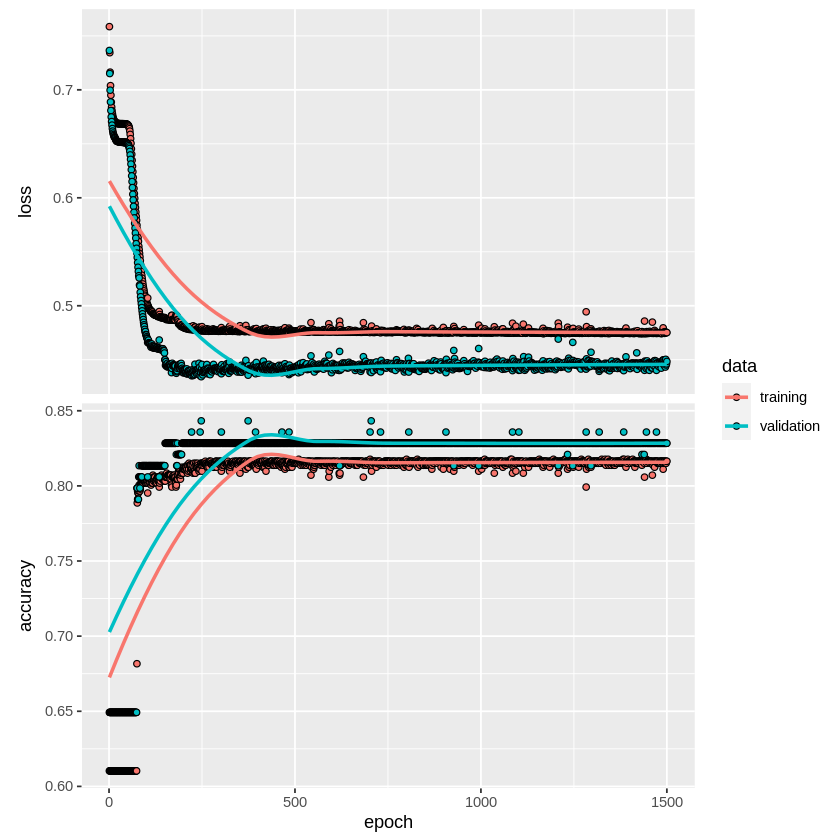

In [338]:
plot(fitModel)

In [339]:
submit_matrix = as.matrix(submit_df[-ncol(submit_df)])
pred = model %>% predict_classes(submit_matrix)

In [340]:
jawab = data.frame(
  PassengerId = submit$passenger_id,
  Survived = pred
)
write.csv(jawab,"jawaban.csv",row.names = FALSE)